In [1]:
library(dplyr)

library(caret)
library(sjPlot) # elbow method to find out k

library(class) # access the knn() function
library(FNN)

library(ISLR)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: ggplot2

Registered S3 methods overwritten by 'parameters':
  method                           from      
  as.double.parameters_kurtosis    datawizard
  as.double.parameters_skewness    datawizard
  as.double.parameters_smoothness  datawizard
  as.numeric.parameters_kurtosis   datawizard
  as.numeric.parameters_skewness   datawizard
  as.numeric.parameters_smoothness datawizard
  print.parameters_distribution    datawizard
  print.parameters_kurtosis        datawizard
  print.parameters_skewness        datawizard
  summary.parameters_kurtosis      datawizard
  summary.parameters_skewness      datawizard


Attaching package: 'FNN'


The following objects are masked from 'package:class':

    knn, knn.cv




# Does the COVID new_case_counts (over the past x days) and the social indices of a county predict aggregated employment rates relative to last year?
### So if I use the mean employment rate over the past x days, does that predict the mean employment rate over the next x day period?

## import data and check data attributes (NAs, column d_types, etc.)

In [2]:
ml_data <- read.csv('ml_predict_data.csv')

In [3]:
# assign countyname col to ml_data idx
row.names(ml_data) <- ml_data$X
# drop X col
drops <- c('X')
ml_data <- ml_data[, !(names(ml_data) %in% drops)]

In [4]:
# check for missing data
ml_data[!complete.cases(ml_data),]

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"


avg_perc_change,new_case_count_sum,religion,civic,charitable,fraternal,union,voteage,local,state,...,politicalacts,ethnic,ethnichpn,education,incomeequal,employ,genderincome,language,commu,nonelder
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [5]:
# check columns classes
sapply(ml_data, class)

avg_perc_change new_case_count_sum           religion              civic 
         "numeric"          "integer"          "numeric"          "numeric" 
        charitable          fraternal              union            voteage 
         "numeric"          "numeric"          "numeric"          "numeric" 
             local              state            federal      politicalacts 
         "numeric"          "numeric"          "numeric"          "numeric" 
            ethnic          ethnichpn          education        incomeequal 
         "numeric"          "numeric"          "numeric"          "numeric" 
            employ       genderincome           language              commu 
         "numeric"          "numeric"          "numeric"          "numeric" 
          nonelder 
         "numeric"

## check target variable distribution

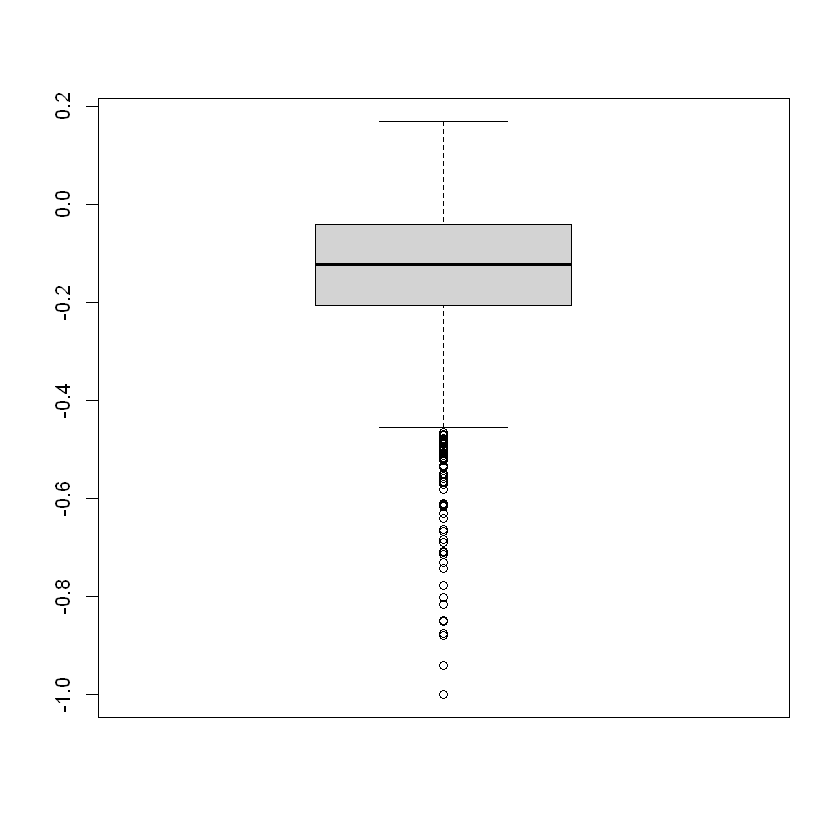

In [6]:
# check distribtuion of target variable
b <- boxplot(ml_data$avg_perc_change)

## randomize, scale and split data to train & test sets

In [7]:
# function to scale X data
normalize <- function(x) {
    return((x - min(x))/(max(x) - min(x)))
}

In [8]:
set.seed(1)
#create an index to split the data: 80% training and 20% test
index = round(nrow(ml_data)*0.2,digits=0)
#sample randomly throughout the dataset and keep the total number equal to the value of index
test.indices = sample(1:nrow(ml_data), index)

#80% training set
train = ml_data[-test.indices,] 
#20% test set
test = ml_data[test.indices,] 

train_x_scaled = data.frame(lapply(train[, 2:21], normalize))
train_y = train[,2]

test_x_scaled = data.frame(lapply(test[, 2:21], normalize))
test_y = test[,2]

## find the best value of k

### using the elbow method

In [9]:
# sjPlot::sjc.elbow(rbind(train_x_scaled, test_x_scaled))

### using the caret package

In [10]:
# The tuneLength parameter tells the algorithm to try different default values
# for the main parameter
set.seed(1)
ctrl <- trainControl(method = "repeatedcv", repeats = 2)
knnFit <- caret::train(avg_perc_change ~ ., data = train, method = "knn", trControl = ctrl,
    preProcess = c("center", "scale"), tuneLength = 20)
knnFit

k-Nearest Neighbors 

947 samples
 20 predictor

Pre-processing: centered (20), scaled (20) 
Resampling: Cross-Validated (10 fold, repeated 2 times) 
Summary of sample sizes: 854, 851, 853, 852, 853, 852, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared    MAE      
   5  0.1789501  0.03235133  0.1297390
   7  0.1733003  0.03976296  0.1249203
   9  0.1715256  0.03852065  0.1231777
  11  0.1690879  0.04859412  0.1216246
  13  0.1677229  0.05197411  0.1211286
  15  0.1669249  0.05762919  0.1206397
  17  0.1665055  0.05855529  0.1204732
  19  0.1658286  0.06185180  0.1195796
  21  0.1652498  0.06699059  0.1191978
  23  0.1648331  0.06863608  0.1187171
  25  0.1648957  0.06968779  0.1185809
  27  0.1647099  0.07086546  0.1184485
  29  0.1648763  0.06916393  0.1185996
  31  0.1651246  0.06610138  0.1187188
  33  0.1652275  0.06394216  0.1188086
  35  0.1654429  0.06211670  0.1187884
  37  0.1654325  0.06239666  0.1185376
  39  0.1653158  0.06303987  0.1184621
  4

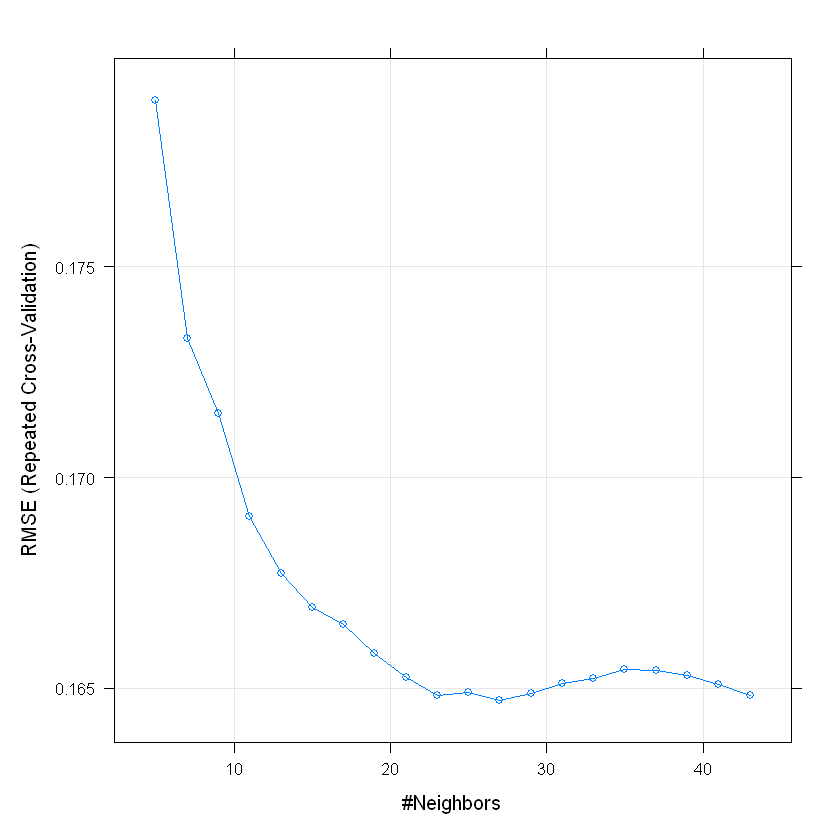

In [11]:
#Use plots to see optimal number of clusters:
#Plotting yields Number of Neighbours Vs accuracy (based on repeated cross validation)
plot(knnFit)

In [12]:
predictions <- knn(train=train_x_scaled, test=test_x_scaled, cl=train_y, k = 25)

In [14]:
reg_results <- knn.reg(as.data.frame(train_x_scaled), as.data.frame(test_x_scaled), train_y, k = 25)

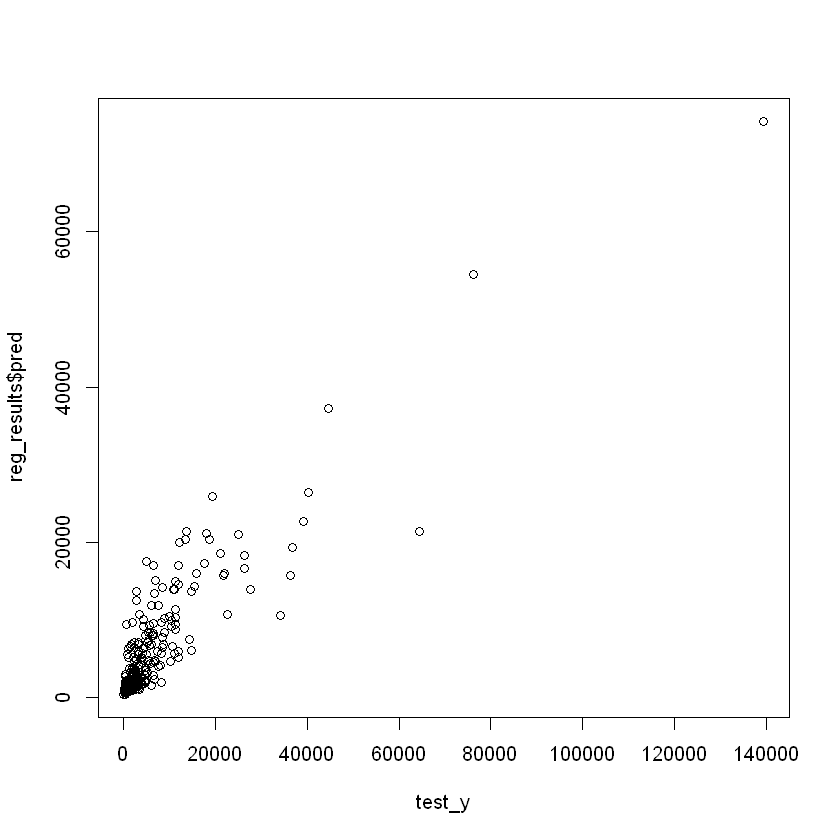

In [15]:
plot(test_y, reg_results$pred)

If the values were perfectly predicted, we would expect to see points along the y = x line (the lower-left to upper-right diagonal if the scales on each axis of the plot are the same).

# final RSME: 0.1647099

roc_auc_score coincides with “the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one”.
In other words, if we take any two observations a and b such that a > b, then roc_auc_score is equal to the probability that our model actually ranks a higher than b.

## naive_roc_auc_score 
https://towardsdatascience.com/how-to-calculate-roc-auc-score-for-regression-models-c0be4fdf76bb

In [18]:
naive_roc_auc_score <- function(y_true, y_pred) {
    num_same_sign <- 0
    num_pairs <- 0 
    
    for(a in 1:length(y_true))
    {
        for(b in 1:length(y_true))
        {
            if (y_true[a] > y_true[b]) {
                
                num_pairs <- num_pairs + 1
                
                if (y_pred[a] > y_pred[b]) {
                
                    num_same_sign <- num_same_sign + 1
                }
                else if (y_pred[a] == y_pred[b]) {
                    
                    num_same_sign <- num_same_sign + .5
                }
            }
        }
    }
    num_same_sign / num_pairs
}

In [19]:
naive_roc_auc_score(test_y, reg_results$pred)

[1] 0.8129381